In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib
import nilearn
from nilearn.plotting import plot_stat_map, plot_glass_brain
import pickle
import json
from typing import Dict, List, Tuple
from tqdm import tqdm
import warnings
from scipy import stats
from scipy.stats import sem
warnings.filterwarnings('ignore')

import networkx as nx
from natsort import natsorted
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from scipy.ndimage import gaussian_filter1d

# Set style for all plots
plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'svg.fonttype': 'none',
    'figure.titlesize': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 8,
    'ytick.labelsize': 6,
    'xtick.labelsize': 6,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})

In [2]:
 # Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")

In [3]:
# %%
# Base directory for analysis outputs
OUTPUT_DIR = Path(scratch_dir) / "output_RR"
SAVE_DIR = Path(OUTPUT_DIR) / "00_final_figures"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

N_STATES_RANGE = range(2, 20)

# Groups and their data paths
GROUPS = ['affair', 'paranoia', 'combined']

# Colors for plotting
COLORS = {
    'affair': '#E1BE6A',      # Yellow/colorblind friendly
    'affair_light': '#F2CB69', # Light yellow/colorblind friendly
    'paranoia': '#40B0A6',    # Green/colorblind friendly
    'paranoia_light': '#90ee90', # Light green/colorblind friendly
    'combined': '#6B15A7',    # Purple/colorblind friendly
    'combined_light': '#C448C5', # Light purple/colorblind friendly
    'balanced': '#3096DF',   # Blue/colorblind friendly
    'balanced_light': '#BFF5F9' # Light blue/colorblind friendly
}

In [4]:
SAVE_DIR_FIG2 = Path(SAVE_DIR) / "figure2"
SAVE_DIR_FIG2.mkdir(parents=True, exist_ok=True)

In [5]:
group_tracking_data = pd.read_csv(Path(OUTPUT_DIR) / "06_state_pattern_cluster" / "th_085" / "pattern_tracking.csv")

In [6]:
# Group by the 'Group' column
grouped_data = group_tracking_data.groupby('Group')

# Process each group separately
for group, df in grouped_data:
    if group == 'combined':
        print("Processing group for cluster plot:", group)
    
        # Debug: print column names
        print(f"Columns in dataframe: {df.columns.tolist()}")
        
        # Ensure we have required columns
        required_cols = ['Model', 'Sorted_State_Index', 'Cluster_ID']
        if not all(col in df.columns for col in required_cols):
            print(f"Missing required columns for {group}. Skipping.")
            continue
        
        # Sort by model using natsort
        model_order = natsorted(df['Model'].unique())
        df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)
        df = df.sort_values(by=['Model', 'Sorted_State_Index'])
        
        # Remove duplicates
        df = df.drop_duplicates(subset=['Model', 'Sorted_State_Index'])
        
        # Create state-cluster heatmap for easier visual pattern identification
        try:
            # Convert Sorted_State_Index to string for proper pivoting
            df['Sorted_State_Index'] = df['Sorted_State_Index'].astype(str)
            
            # Create pivot table
            pivot_df = df.pivot(index='Model', columns='Sorted_State_Index', values='Cluster_ID')
            
            # Sort rows using natural sort
            pivot_df = pivot_df.loc[natsorted(pivot_df.index)]
            pivot_df = pivot_df[natsorted(pivot_df.columns)]
            
            # Create a mask for values > 4 to apply alpha
            mask = pivot_df > 4
            
            # Create heatmap with dynamic sizing based on data and square cells
            num_models = len(pivot_df)
            num_states = len(pivot_df.columns)
            
            # Make cells more square by adjusting aspect ratio
            fig_width = 20 * 0.18
            fig_height = num_models * 0.18
            aspect_ratio = fig_width / fig_height
            
            # Adjust figure size for square cells
            plt.figure(figsize=(fig_width, fig_height))
            
            # Determine max cluster ID for colormap
            max_cluster = df['Cluster_ID'].max()
            
            # Create a custom function to apply alpha to annotations based on value
            def color_annotations(val):
                if val > 4:
                    return {'color': 'black', 'alpha': 0.5}
                else:
                    return {'color': 'black', 'alpha': 1.0}
            
            # Create the heatmap
            # Create a custom colormap with better contrast for text visibility
            cmap = plt.cm.rainbow
            
            # Create the heatmap with adjusted text colors
            ax = sns.heatmap(pivot_df, 
                        annot=True, 
                        fmt='g', 
                        cmap=cmap, 
                        cbar=False,
                        cbar_kws={"shrink": 0.5},  # Make colorbar smaller
                        linewidths=0.5, 
                        linecolor='white',
                        annot_kws={'size': min(5.2, max(6, 10 - 0.1*num_models))},
                        mask=None,
                        alpha=np.where(mask, 0.4, 1.0))  # Apply alpha 0.5 for values > 4
                        
            # Set all text to white for better visibility across all colors
            for text in ax.texts:
                text.set_color('white')
            
            # Set x-axis ticks with appropriate range
            plt.xticks(np.arange(20) + 0.5, range(1, 21))
            plt.yticks(np.arange(len(pivot_df.index)) + 0.5, [mn.replace('combined ', '') for mn in pivot_df.index])
            plt.xlabel('')
            plt.ylabel('')
            
            # Force aspect ratio to make cells more square
            ax.set_aspect(1.0/ax.get_data_ratio()*0.8)  # Adjust the 0.8 multiplier as needed
            
            plt.tight_layout()
            # plt.show()
            plt.savefig(SAVE_DIR_FIG2 / f'{group}_cluster_by_model_heatmap.png', dpi=300, bbox_inches='tight')
            plt.savefig(SAVE_DIR_FIG2 / f'{group}_cluster_by_model_heatmap.svg', dpi=300, bbox_inches='tight')
            # print(f"Successfully created heatmap for {group}")
            plt.close()
        
        except Exception as e:
            print(f"Error creating heatmap for {group}: {str(e)}")

Processing group for cluster plot: combined
Columns in dataframe: ['Group', 'Model', 'Model_Num', 'Original_State_Index', 'Sorted_State_Index', 'Cluster_ID']


In [7]:
fig_width

3.5999999999999996

In [8]:
def load_data(group: str, n_state: int) -> Dict:
    """Load both metrics and summary files."""
    base_path = OUTPUT_DIR / f"04_{group}_hmm_{n_state}states_ntw_native_trimmed" / "statistics"
    
    # Load metrics
    metrics_path = base_path / f"{group}_metrics.pkl"
    try:
        with open(metrics_path, 'rb') as f:
            metrics = pickle.load(f)
    except Exception as e:
        print(f"Error loading metrics for {group}, n_state={n_state}: {e}")
        metrics = None
    
    # Load summary
    summary_path = base_path / f"{group}_summary.json"
    try:
        with open(summary_path, 'r') as f:
            summary = json.load(f)
    except Exception as e:
        print(f"Error loading summary for {group}, n_state={n_state}: {e}")
        summary = None
    
    sequence_path = base_path / f"{group}_state_sequences.npy"
    try:
        sequences = np.load(sequence_path)
    except Exception as e:
        print(f"Error loading sequences for {group}, n_state={n_state}: {e}")
        sequences = None
    
    return {'metrics': metrics, 'summary': summary, 'sequences': sequences}

def extract_model_metrics(data: Dict) -> Dict:
    """Extract relevant metrics from both metrics and summary files."""
    metrics = {}
    
    try:
        metrics_data = data['metrics']
        summary_data = data['summary']
        
        if metrics_data:
            # Get state frequencies and calculate percentage below threshold
            state_freq_mean = metrics_data['subject_consistency']['summary']['state_frequency']['mean']
            metrics['pct_low_freq'] = np.mean(state_freq_mean < 0.1) * 100
            
            # Get pattern correlations variance
            pattern_corr = metrics_data['subject_consistency']['pattern_correlation']
            state_variances = np.var(pattern_corr, axis=0)
            metrics['max_pattern_var'] = np.max(state_variances)
            
            # Get mean pattern stability
            state_props = metrics_data['state_properties']
            pattern_stabilities = []
            for key in state_props.keys():
                if isinstance(key, (int, str)) and key != 'separability':
                    if isinstance(key, str) and key.isdigit():
                        key = int(key)
                    pattern_stabilities.append(state_props[key]['pattern_stability'])
            metrics['mean_pattern_stability'] = np.mean(pattern_stabilities)
        
        if summary_data:
            # Extract BIC and log-likelihood
            metrics['bic'] = summary_data['model_performance']['bic']
            metrics['log_likelihood'] = summary_data['model_performance']['log_likelihood']
        
    except Exception as e:
        print(f"Error extracting metrics: {e}")
        return None
        
    return metrics

In [9]:
cluster_info_file = Path(OUTPUT_DIR) / "06_state_pattern_cluster" / "th_085" / "cluster_info.json"
with open(cluster_info_file, 'r') as f:
    cluster_info = json.load(f)


## sequence plot

In [10]:
affair_sequences = load_data('affair', 3)['sequences']
paranoia_sequences = load_data('paranoia', 3)['sequences']




In [11]:
def plot_brain_state_sequences(state_sequences, cmap='viridis', figsize=(4, 2), 
                              title="Brain State Sequences", save_path=None,
                              group='affair', state_mapping=None):
    """
    Plot brain state sequences as color-coded bars with no gaps between subjects.
    
    Parameters:
    -----------
    state_sequences : numpy.ndarray
        Array of shape (n_subjects, n_timepoints) containing state labels (0, 1, 2)
    cmap : str or matplotlib.colors.Colormap
        Colormap to use for the states
    figsize : tuple
        Figure size (width, height)
    title : str
        Plot title
    save_path : str, optional
        Path to save the figure
    group : str
        Which group the data belongs to ('affair' or 'paranoia')
    state_mapping : dict, optional
        Dictionary mapping states between groups
    """
    n_subjects, n_timepoints = state_sequences.shape
    
    # Create a copy of the state sequences to avoid modifying the original
    mapped_sequences = state_sequences.copy()
    
    # Apply state mapping if needed
    if state_mapping is not None and group == 'paranoia':
        # For paranoia group, directly map the state values using paranoia_to_affair mapping
        for i in range(n_subjects):
            for t in range(n_timepoints):
                original_state = state_sequences[i, t]
                # Use the correct mapping direction: paranoia_to_affair
                mapped_sequences[i, t] = state_mapping['paranoia_to_affair'].get(original_state, original_state)
    
    # Get the number of unique states after mapping
    n_states = len(np.unique(mapped_sequences))
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define colors for each state
    if isinstance(cmap, str):
        if cmap == 'categorical':
            # Use distinct colors for categorical data
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
            cmap = mcolors.ListedColormap(colors[:n_states])
        else:
            cmap = plt.get_cmap(cmap, n_states)
    
    # Plot the grid using imshow
    im = ax.imshow(mapped_sequences, aspect='auto', cmap=cmap, 
                  interpolation='nearest', origin='lower',
                  extent=[0, n_timepoints-1, -0.5, n_subjects-0.5])
    
    # Set axis limits
    ax.set_xlim(0, n_timepoints-1)
    ax.set_ylim(-0.5, n_subjects-0.5)
    
    # Add labels and title
    # ax.set_xlabel('Time Points')
    # ax.set_ylabel('Subject')
    # ax.set_title(title)
    
    # Add y-ticks for each subject
    ax.set_yticks(np.arange(n_subjects))
    ax.set_yticklabels([f'{i+1}' for i in range(n_subjects)])
    
    # Add colorbar
    # cbar = plt.colorbar(im, ax=ax, ticks=np.arange(n_states))
    # cbar.set_label('Brain State')
    
    # Set colorbar labels
    # cbar.set_ticklabels([f'State {i}' for i in range(n_states)])
    
    plt.tight_layout()
    plt.show()
    plt.close()
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax

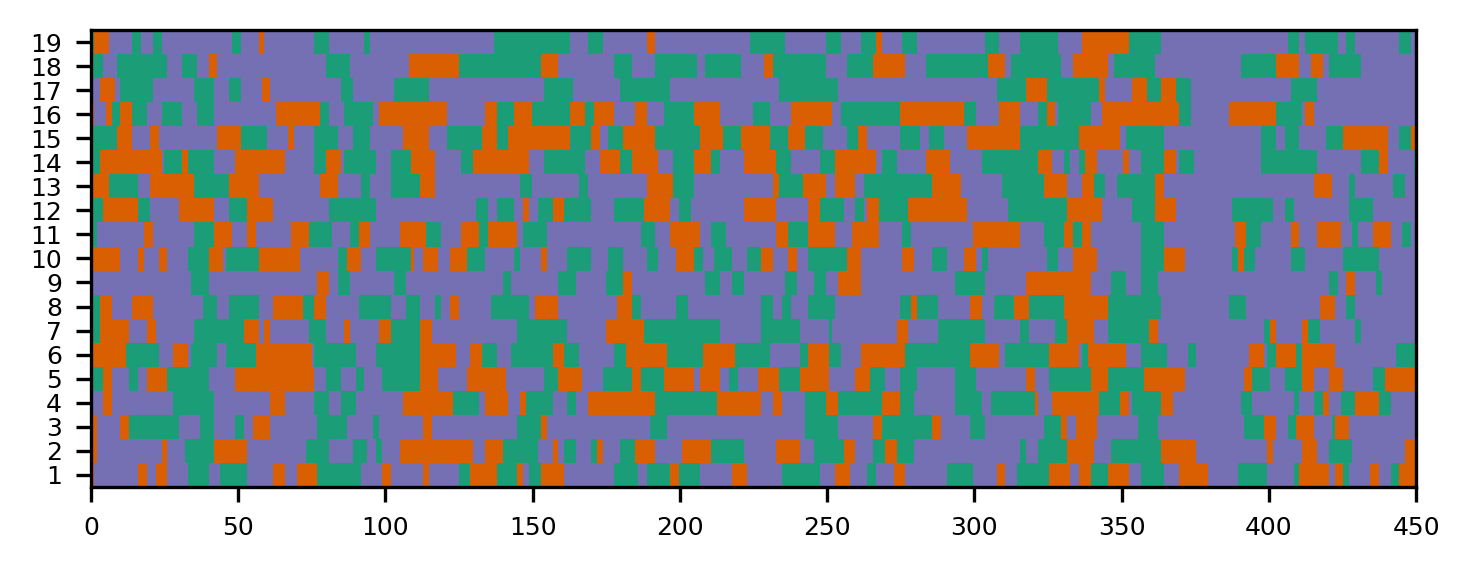

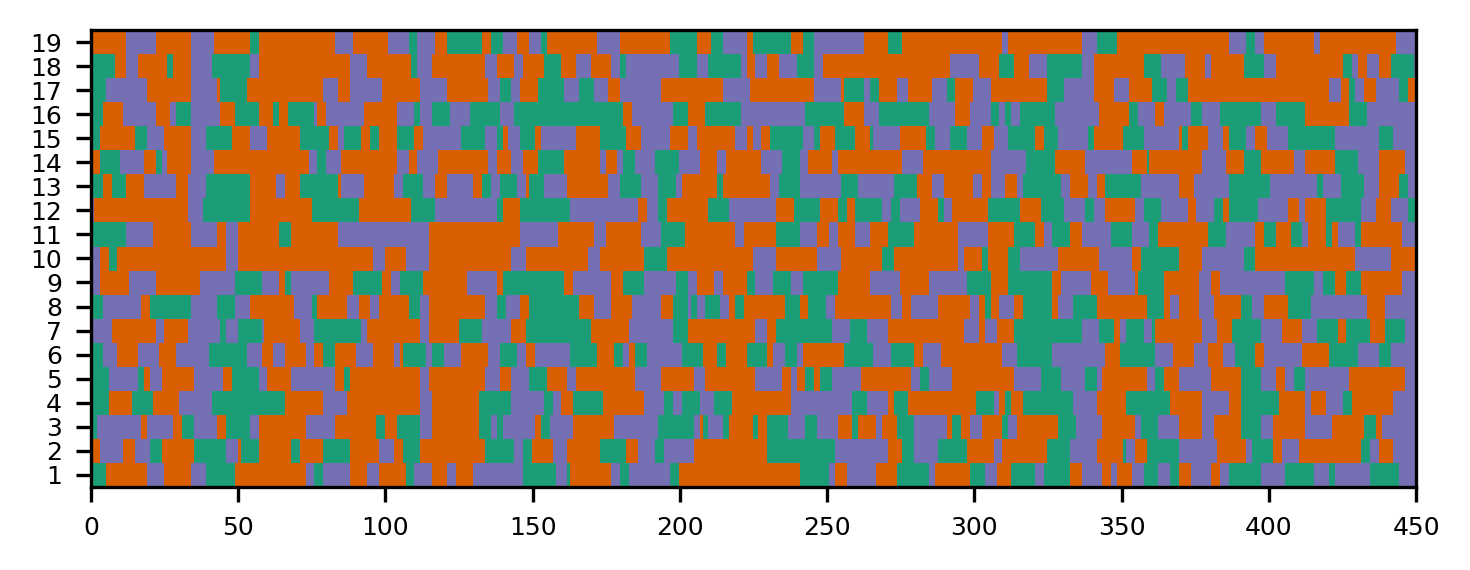

In [12]:
# State mapping
state_mapping = {
    'affair_to_paranoia': {0: 1, 1: 2, 2: 0},
    'paranoia_to_affair': {1: 0, 2: 1, 0: 2}
}

# Define a consistent colormap
custom_cmap = mcolors.ListedColormap(['#1b9e77', '#d95f02', '#7570b3'])

# Plot affair group
fig_affair, ax_affair = plot_brain_state_sequences(
    affair_sequences,
    cmap=custom_cmap,
    figsize=(5, 2),
    title="",
    group='affair',
    state_mapping=state_mapping
)

# Plot paranoia group with consistent colors
fig_paranoia, ax_paranoia = plot_brain_state_sequences(
    paranoia_sequences,
    cmap=custom_cmap,
    figsize=(5, 2),
    title="",
    group='paranoia',
    state_mapping=state_mapping
)

In [13]:
def plot_state_probabilities(state_sequences, figsize=(3, 1), 
                            title="Probability of state expression over time",
                            colors=None, save_path=None, 
                            group='affair', state_mapping=None):
    """
    Create a stacked area plot showing probability of each state over time.
    
    Parameters:
    -----------
    state_sequences : numpy.ndarray
        Array of shape (n_subjects, n_timepoints) containing state labels (0, 1, 2)
    figsize : tuple
        Figure size (width, height)
    title : str
        Plot title
    colors : list, optional
        List of colors for each state
    save_path : str, optional
        Path to save the figure
    group : str
        Which group the data belongs to ('affair' or 'paranoia')
    state_mapping : dict, optional
        Dictionary mapping states between groups
    """
    n_subjects, n_timepoints = state_sequences.shape
    n_states = len(np.unique(state_sequences))
    
    # Define colors if not provided
    if colors is None:
        colors = ['#1b9e77', '#d95f02', '#7570b3']  # ColorBrewer colors
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate probability of each state at each timepoint
    state_probs = np.zeros((n_states, n_timepoints))
    
    # Apply mapping if provided
    if state_mapping is not None and group == 'paranoia':
        # For paranoia group, directly use the paranoia_to_affair mapping
        paranoia_to_affair = state_mapping['paranoia_to_affair']
        
        # Calculate probabilities with the mapping applied
        for t in range(n_timepoints):
            for paranoia_state in range(n_states):
                # Map the paranoia state to the corresponding affair state
                affair_state = paranoia_to_affair.get(paranoia_state, paranoia_state)
                # Add the probability to the corresponding affair state position
                state_probs[affair_state, t] = np.mean(state_sequences[:, t] == paranoia_state)
    else:
        # For affair group or if no mapping provided, use states as-is
        for t in range(n_timepoints):
            for s in range(n_states):
                state_probs[s, t] = np.mean(state_sequences[:, t] == s)
    
    # Create x-axis values
    x = np.arange(n_timepoints)
    
    # Create stacked area plot
    ax.stackplot(x, state_probs, labels=[f'#{i+1}' for i in range(n_states)], 
                colors=colors, alpha=0.9)
    
    # Add labels and title
    # ax.set_xlabel('Time')
    # ax.set_ylabel('Probability')
    # ax.set_title(title, fontsize=16, fontweight='bold')
    
    # Set axis limits
    ax.set_xlim(0, n_timepoints-1)
    ax.set_ylim(0, 1)
    
    # Add grid
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax

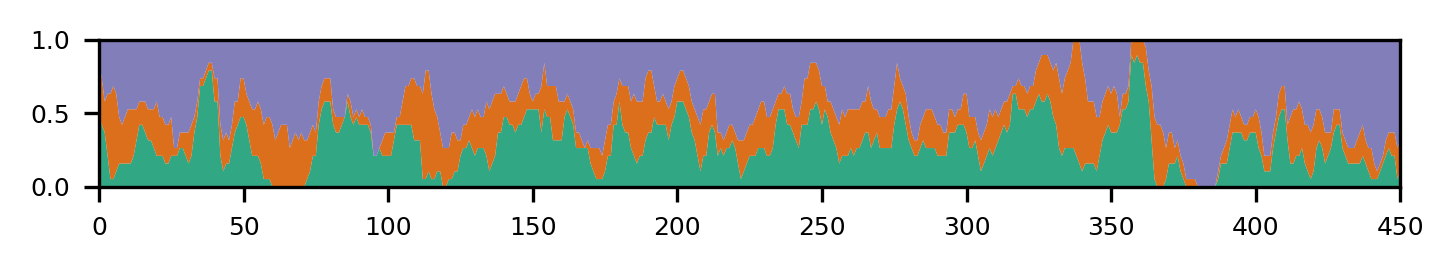

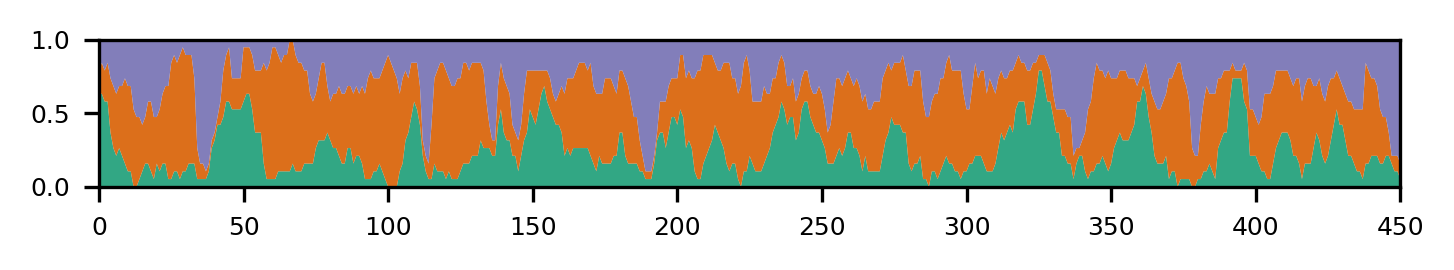

In [14]:
# State mapping
state_mapping = {
    'affair_to_paranoia': {0: 1, 1: 2, 2: 0},
    'paranoia_to_affair': {1: 0, 2: 1, 0: 2}
}

# Define consistent colors for all states
state_colors = ['#1b9e77', '#d95f02', '#7570b3']  # Teal, orange, purple

# Plot affair group
fig_affair, ax_affair = plot_state_probabilities(
    affair_sequences,
    figsize=(5, 1),
    title="",
    colors=state_colors,
    group='affair',
    state_mapping=state_mapping
)

# Plot paranoia group with consistent colors
fig_paranoia, ax_paranoia = plot_state_probabilities(
    paranoia_sequences,
    figsize=(5, 1),
    title="",
    colors=state_colors,
    group='paranoia',
    state_mapping=state_mapping
)

In [15]:
def create_selection_plot(groups=['affair', 'paranoia', 'combined'], figsize=(12, 4)):
    """
    Create model selection plots showing BIC and other metrics across different numbers of states.
    
    Parameters:
    -----------
    groups : list
        List of groups to plot
    figsize : tuple
        Figure size (width, height)
    """
    fig, axes = plt.subplots(1, len(groups), figsize=figsize, sharey=True)
    if len(groups) == 1:
        axes = [axes]
    
    for i, group in enumerate(groups):
        n_states_list = []
        bic_values = []
        log_likelihood_values = []
        
        # Collect data for each number of states
        for n_states in N_STATES_RANGE:
            try:
                data = load_data(group, n_states)
                if data['summary'] is not None:
                    n_states_list.append(n_states)
                    bic_values.append(data['summary']['model_performance']['bic'])
                    log_likelihood_values.append(data['summary']['model_performance']['log_likelihood'])
            except Exception as e:
                print(f"Error loading data for {group}, n_states={n_states}: {e}")
                continue
        
        if len(n_states_list) > 0:
            # Plot BIC (lower is better)
            ax = axes[i]
            ax2 = ax.twinx()
            
            line1 = ax.plot(n_states_list, bic_values, 'o-', color=COLORS[group], 
                           linewidth=2, markersize=6, label='BIC')
            line2 = ax2.plot(n_states_list, log_likelihood_values, 's--', 
                            color=COLORS[group + '_light'], linewidth=2, markersize=6, 
                            label='Log Likelihood', alpha=0.7)
            
            ax.set_xlabel('Number of States')
            ax.set_ylabel('BIC (lower is better)', color=COLORS[group])
            ax2.set_ylabel('Log Likelihood', color=COLORS[group + '_light'])
            ax.set_title(f'{group.capitalize()} Group')
            
            # Color the y-axis labels
            ax.tick_params(axis='y', labelcolor=COLORS[group])
            ax2.tick_params(axis='y', labelcolor=COLORS[group + '_light'])
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            # Add legend
            lines = line1 + line2
            labels = [l.get_label() for l in lines]
            ax.legend(lines, labels, loc='upper right')
        else:
            axes[i].text(0.5, 0.5, f'No data available\nfor {group}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{group.capitalize()} Group')
    
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    plt.savefig(SAVE_DIR_FIG2 / 'model_selection_plot.png', dpi=300, bbox_inches='tight')
    plt.savefig(SAVE_DIR_FIG2 / 'model_selection_plot.svg', dpi=300, bbox_inches='tight')
    plt.close()
    
    return fig, axes


In [16]:
def plot_state_consistency(n_states=[3, 4], groups=['affair', 'paranoia', 'combined'], figsize=(10, 3)):
    """
    Plot state consistency metrics across different groups and numbers of states.
    
    Parameters:
    -----------
    n_states : list
        List of numbers of states to plot
    groups : list
        List of groups to plot
    figsize : tuple
        Figure size (width, height)
    """
    fig, axes = plt.subplots(1, len(n_states), figsize=figsize)
    if len(n_states) == 1:
        axes = [axes]
    
    for i, n_state in enumerate(n_states):
        ax = axes[i]
        
        group_names = []
        pct_low_freq_values = []
        pattern_stability_values = []
        max_pattern_var_values = []
        
        for group in groups:
            try:
                data = load_data(group, n_state)
                metrics = extract_model_metrics(data)
                
                if metrics is not None:
                    group_names.append(group)
                    pct_low_freq_values.append(metrics.get('pct_low_freq', 0))
                    pattern_stability_values.append(metrics.get('mean_pattern_stability', 0))
                    max_pattern_var_values.append(metrics.get('max_pattern_var', 0))
                    
            except Exception as e:
                print(f"Error loading data for {group}, n_states={n_state}: {e}")
                continue
        
        if len(group_names) > 0:
            x_pos = np.arange(len(group_names))
            width = 0.25
            
            # Plot bars for different metrics
            bars1 = ax.bar(x_pos - width, pct_low_freq_values, width, 
                          label='% Low Freq States', color='lightblue', alpha=0.7)
            bars2 = ax.bar(x_pos, [s * 100 for s in pattern_stability_values], width,
                          label='Pattern Stability (×100)', color='lightgreen', alpha=0.7)
            bars3 = ax.bar(x_pos + width, [v * 100 for v in max_pattern_var_values], width,
                          label='Max Pattern Var (×100)', color='lightcoral', alpha=0.7)
            
            ax.set_xlabel('Groups')
            ax.set_ylabel('Metric Values')
            ax.set_title(f'{n_state} States')
            ax.set_xticks(x_pos)
            ax.set_xticklabels([g.capitalize() for g in group_names])
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Add value labels on bars
            def add_value_labels(bars):
                for bar in bars:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.1f}', ha='center', va='bottom', fontsize=8)
            
            add_value_labels(bars1)
            add_value_labels(bars2)
            add_value_labels(bars3)
        else:
            ax.text(0.5, 0.5, f'No data available\nfor {n_state} states', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{n_state} States')
    
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    states_str = '_'.join(map(str, n_states))
    plt.savefig(SAVE_DIR_FIG2 / f'state_consistency_{states_str}states.png', dpi=300, bbox_inches='tight')
    plt.savefig(SAVE_DIR_FIG2 / f'state_consistency_{states_str}states.svg', dpi=300, bbox_inches='tight')
    plt.close()
    
    return fig, axes


## Supplementary figures

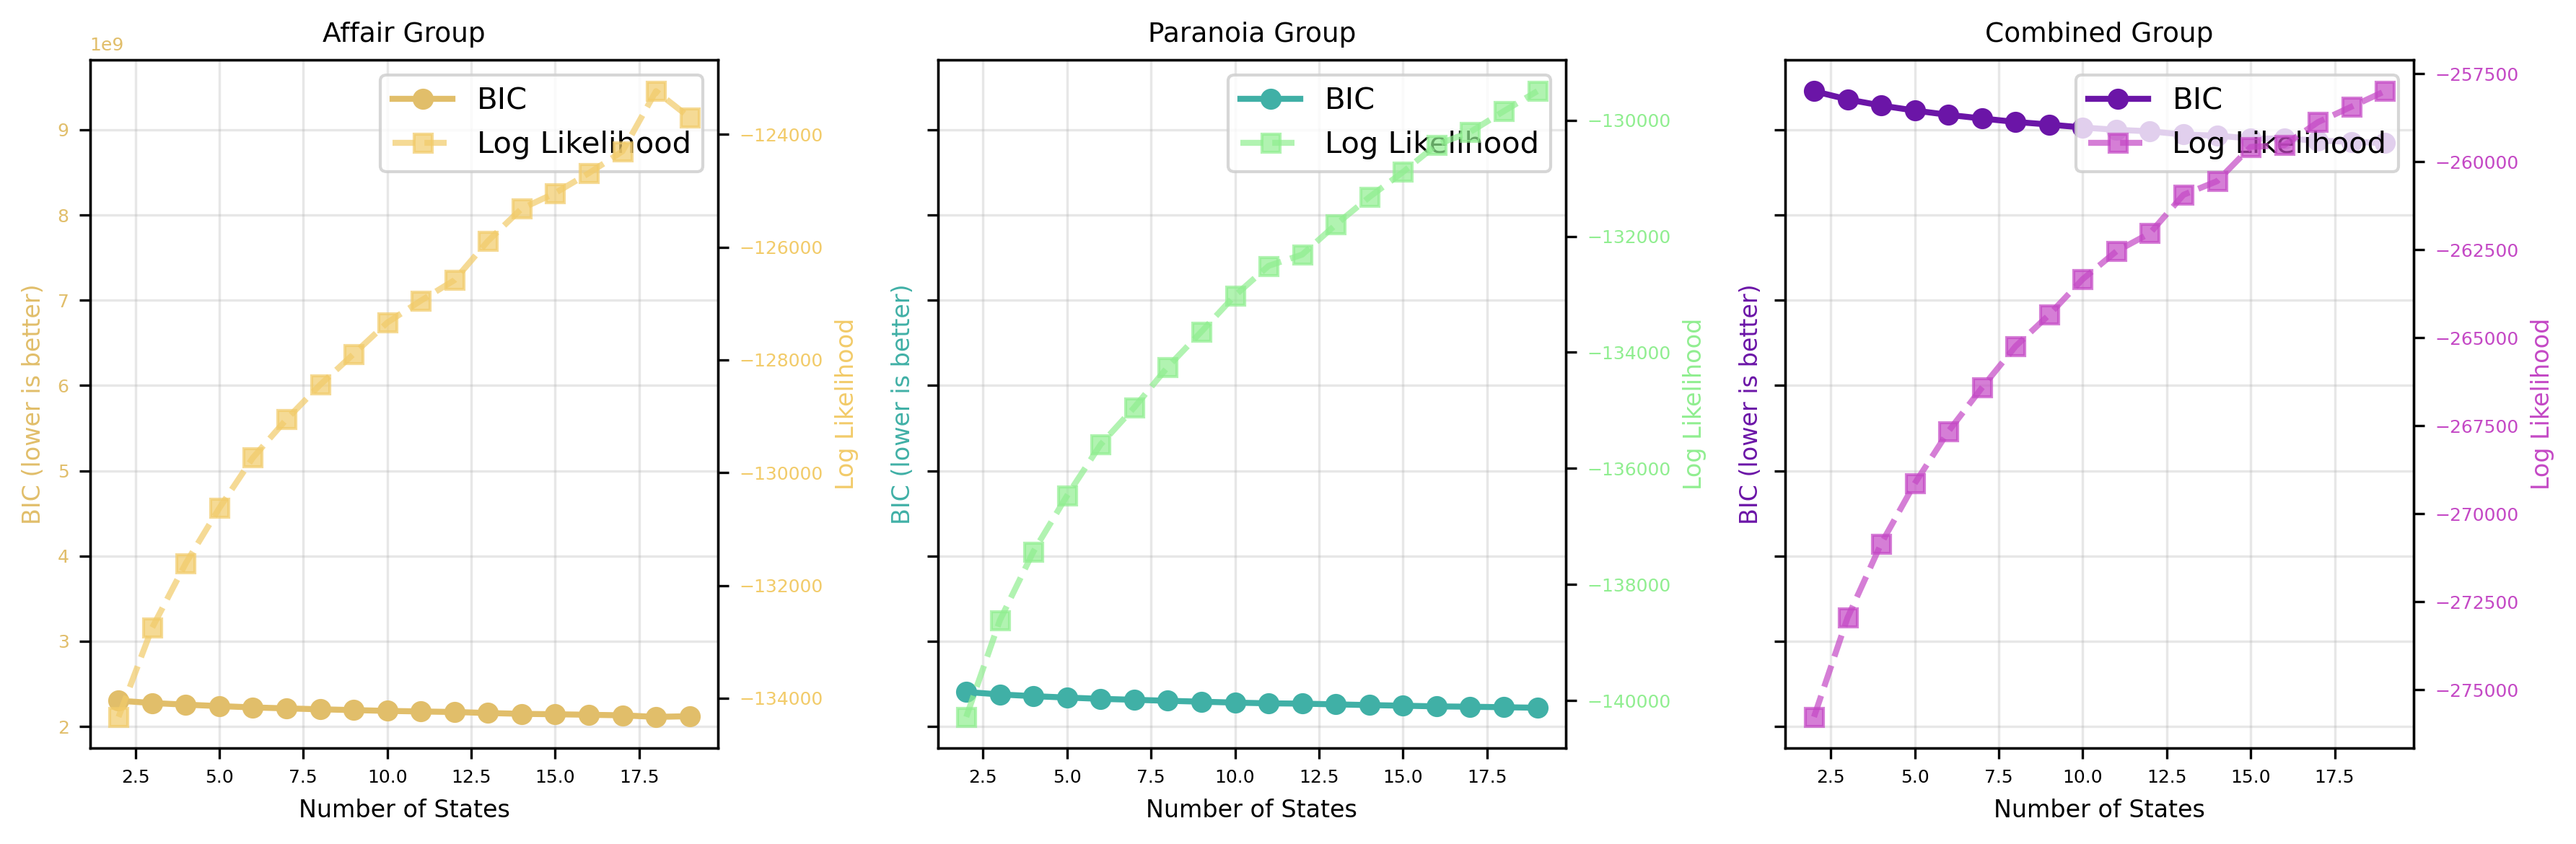

(<Figure size 3600x1200 with 6 Axes>,
 array([<Axes: title={'center': 'Affair Group'}, xlabel='Number of States', ylabel='BIC (lower is better)'>,
        <Axes: title={'center': 'Paranoia Group'}, xlabel='Number of States', ylabel='BIC (lower is better)'>,
        <Axes: title={'center': 'Combined Group'}, xlabel='Number of States', ylabel='BIC (lower is better)'>],
       dtype=object))

In [17]:
create_selection_plot(groups=['affair', 'paranoia', 'combined'])

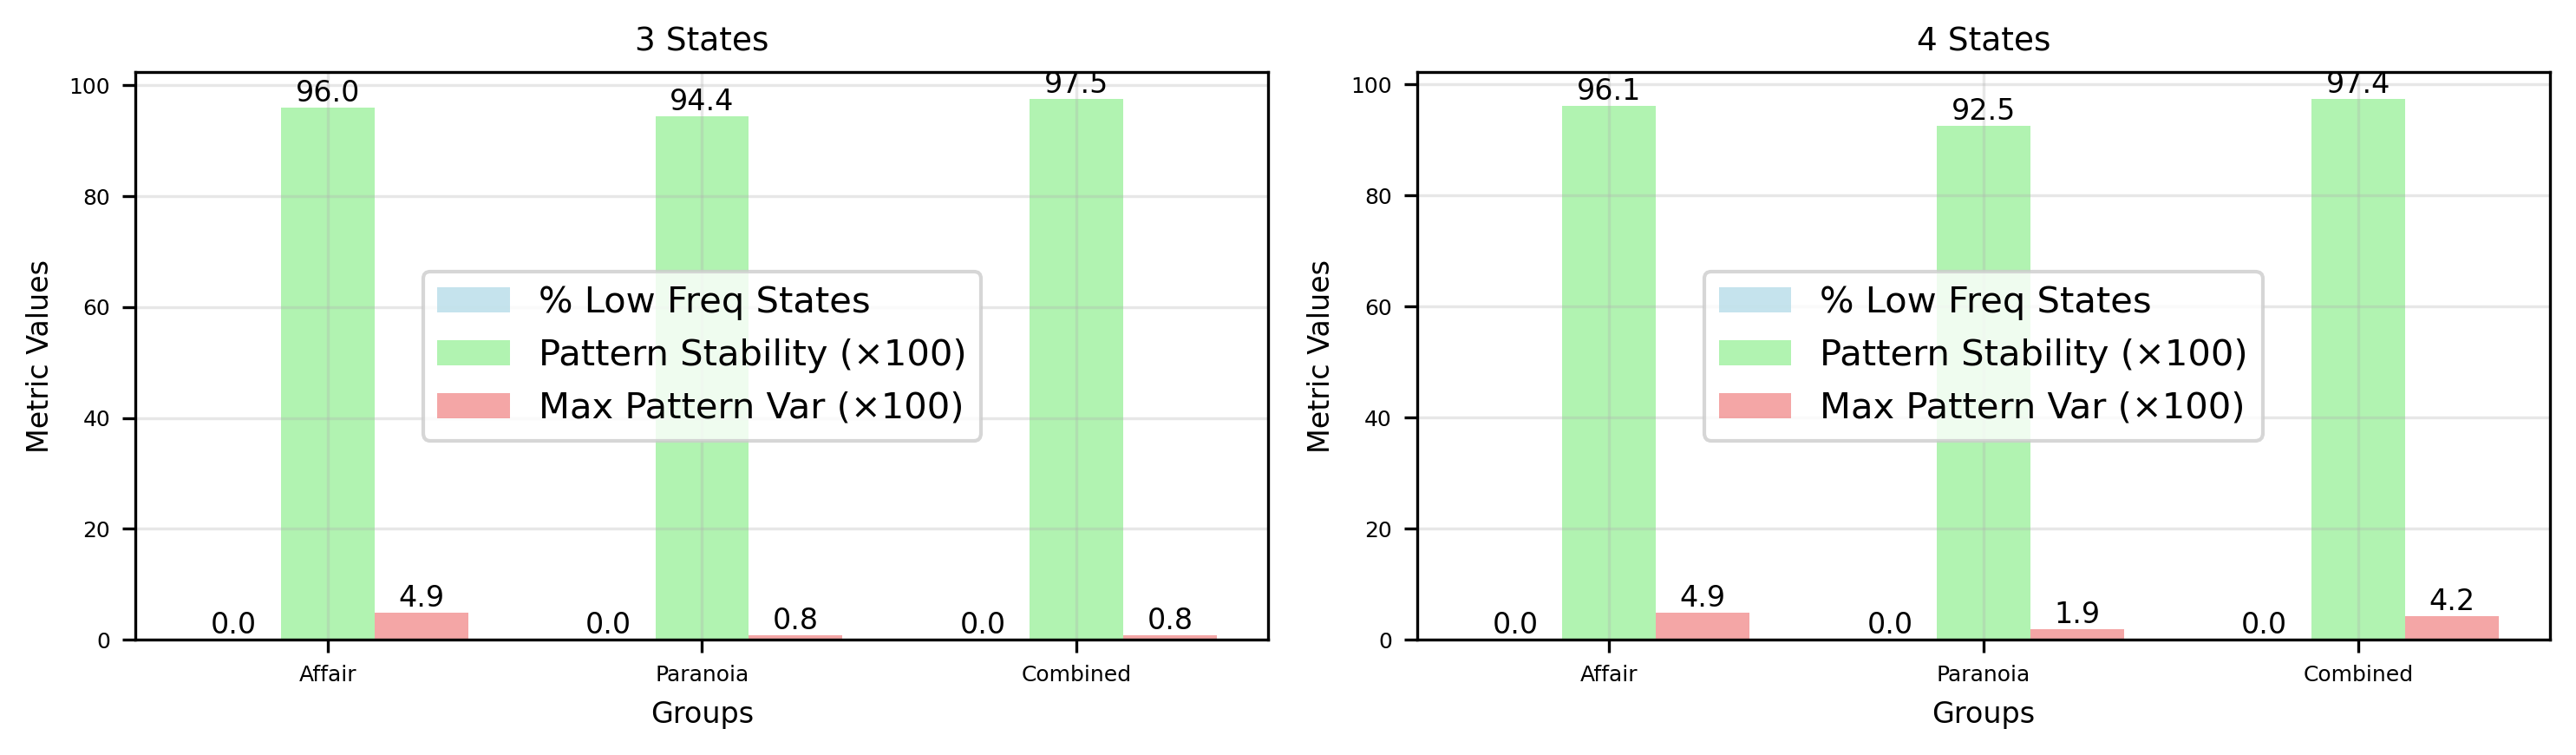

(<Figure size 3000x900 with 2 Axes>,
 array([<Axes: title={'center': '3 States'}, xlabel='Groups', ylabel='Metric Values'>,
        <Axes: title={'center': '4 States'}, xlabel='Groups', ylabel='Metric Values'>],
       dtype=object))

In [18]:
plot_state_consistency(n_states=[3, 4], groups=['affair', 'paranoia', 'combined'], figsize=(10, 3))

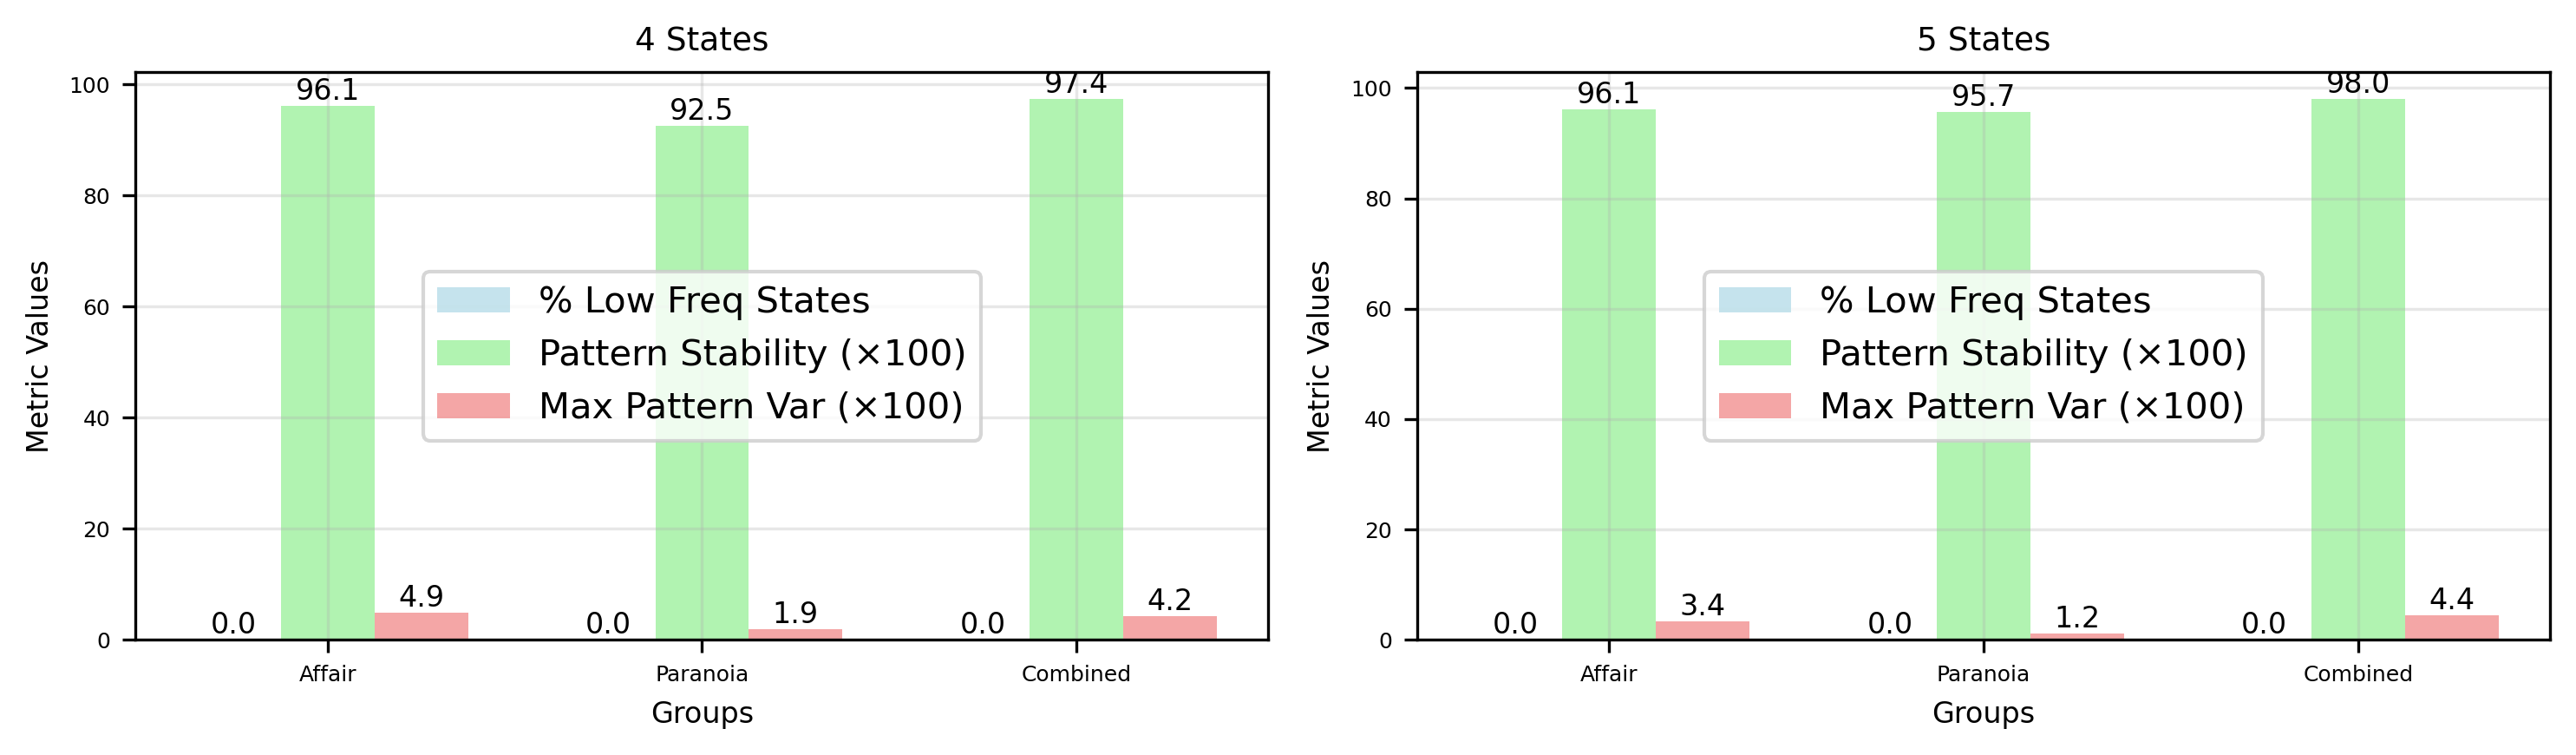

(<Figure size 3000x900 with 2 Axes>,
 array([<Axes: title={'center': '4 States'}, xlabel='Groups', ylabel='Metric Values'>,
        <Axes: title={'center': '5 States'}, xlabel='Groups', ylabel='Metric Values'>],
       dtype=object))

In [19]:
plot_state_consistency(n_states=[4, 5], groups=['affair', 'paranoia', 'combined'], figsize=(10, 3))

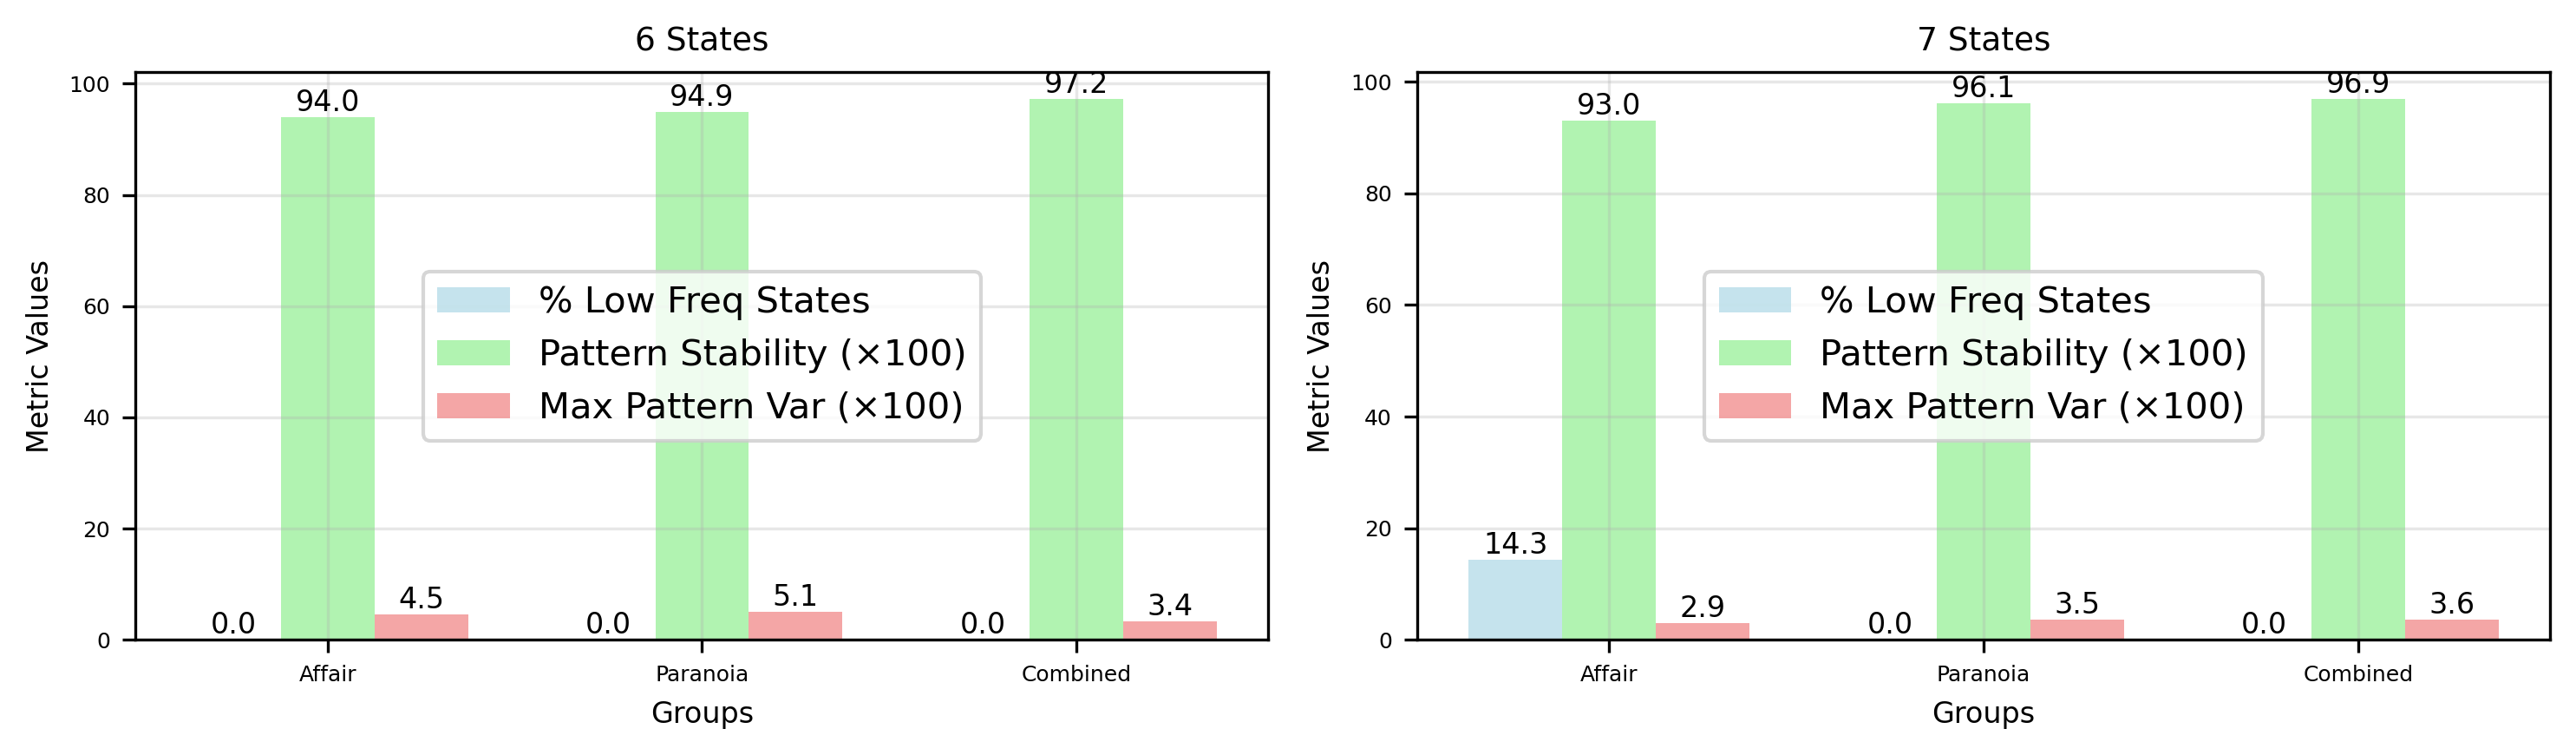

(<Figure size 3000x900 with 2 Axes>,
 array([<Axes: title={'center': '6 States'}, xlabel='Groups', ylabel='Metric Values'>,
        <Axes: title={'center': '7 States'}, xlabel='Groups', ylabel='Metric Values'>],
       dtype=object))

In [20]:
plot_state_consistency(n_states=[6, 7], groups=['affair', 'paranoia', 'combined'], figsize=(10, 3))